In [98]:
%pip install -e git+https://github.com/UN-GCPDS/python-gcpds.MI_prediction.git#egg=MI_prediction

Obtaining MI_prediction from git+https://github.com/UN-GCPDS/python-gcpds.MI_prediction.git#egg=MI_prediction
  Updating ./src/mi-prediction clone
  Running command git fetch -q --tags
  Running command git reset --hard -q 028eecf35851ae48419860e2da0ac678b53265d4
  Preparing metadata (setup.py) ... done
  Attempting uninstall: MI_prediction
    Found existing installation: MI-prediction 0.1
    Uninstalling MI-prediction-0.1:
      Successfully uninstalled MI-prediction-0.1
  Running setup.py develop for MI_prediction
Note: you may need to restart the kernel to use updated packages.


In [1]:
from MI_prediction.Utils.Datasets import  DataLoader_Rest, get_epochs, get_runs, get_labels
from MI_prediction.Datasets import Cho2017_Rest, BNCI2014001_Rest
from MI_prediction.Utils.Preprocess import filterbank_preprocessor, filterbank,FBCSP,moments
from MI_prediction.Utils.Windowers import create_windows
from braindecode.preprocessing.preprocess import exponential_moving_standardize, preprocess, Preprocessor, scale

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import welch

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score,GridSearchCV

from sklearn.preprocessing import StandardScaler
from mne.preprocessing import compute_current_source_density

import time
import pickle

# GIGAScience Cho2017

In [2]:
dl = DataLoader_Rest(dataset_name=Cho2017_Rest())

subjects = np.arange(1,53)
subjects = subjects[(subjects!=32) & (subjects!=46) & (subjects!=49)]

dl.load_data(subject_ids=[1])

In [3]:
duration = dl.dataset.datasets[0].raw.n_times/dl.dataset.datasets[0].raw.info['sfreq']

In [4]:
duration

66.5

In [5]:
fb = filterbank_preprocessor([(8.,15.),(15.,25.)])

preprocessors = [
        Preprocessor('pick_types', eeg=True, meg=False, stim=False),  # Keep EEG sensors
        #Preprocessor(scale, factor=1e6, apply_on_array=True),  # Convert from V to uV
        Preprocessor('filter',l_freq=1., h_freq=None)
        ]

Ch_prep = [
        Preprocessor(compute_current_source_density,copy=False,apply_on_array=False)
        ]

st_offsets, ed_offsets = create_windows(win = 2, start_offset = 5, end_offset = -5, mi_duration = 66, overlap = 0.5)

band to filter: (8.0, 15.0) Hz
band to filter: (15.0, 25.0) Hz


In [6]:
ds_f = filterbank(dl, preprocess=preprocessors, filters=fb, channels_prep=Ch_prep)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 sec)

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)


In [7]:
trials = [tr.get_trials(start_offset=st_offsets, end_offset=ed_offsets) for tr in ds_f]

Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 1024 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for

In [8]:
trials[0]['win_0'].description

,subject,session,run
0,1,session_0,run_0


In [9]:
nw = 0
epochs = [moments(get_epochs(epoch['win_'+str(nw)].split('session')['session_0'])) for epoch in trials]

(1, 64, 5)

In [91]:
epochs_moment[0]

array([[[-1.17937452e-05,  1.46466237e-03,  1.31963700e-01,
         -1.07410565e-01, -1.76281878e-03],
        [-3.26674723e-04,  1.55397481e-03,  1.09921388e-01,
         -1.21023625e-01, -7.33983470e-04],
        [-4.93885600e-04,  2.11796956e-03,  1.45185366e-01,
         -1.23212002e-01, -1.36122643e-03],
        [-4.84158430e-04,  2.57200398e-03,  1.53820783e-01,
         -1.45539373e-01, -2.09650374e-03],
        [-9.28251771e-04,  2.07245443e-03,  1.40653312e-01,
         -1.19709291e-01, -4.41810023e-03],
        [-1.25355087e-03,  1.77596929e-03,  9.95874554e-02,
         -1.02212310e-01, -4.28591622e-03],
        [-6.52026210e-04,  1.43387471e-03,  1.00490756e-01,
         -9.00130123e-02, -2.62859417e-03],
        [-8.09421530e-04,  1.48604077e-03,  9.08286497e-02,
         -1.11315399e-01, -3.15751554e-03],
        [-1.48339430e-03,  1.50293042e-03,  9.39712748e-02,
         -1.23626351e-01, -3.43874737e-04],
        [-7.85883574e-04,  1.53326557e-03,  1.04083344e-01,
    

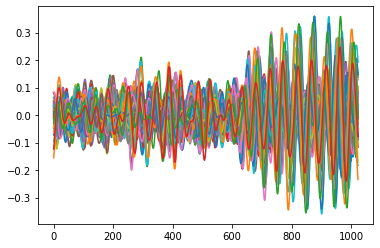

In [60]:
plt.plot(epochs[0][0][0,:,:].T)
plt.show()

In [30]:
768/512

1.5

In [55]:
get_epochs(trial['win_0'].split('session')['session_0'])

(array([[[-4.33680869e-19, -2.34590789e-05,  8.07659490e-06, ...,
          -6.26768172e-03, -6.24713395e-03, -6.28971448e-03],
         [ 7.58941521e-19, -2.62941147e-04, -4.70635743e-04, ...,
          -6.73387200e-03, -6.55070739e-03, -6.41420204e-03],
         [ 4.33680869e-19, -1.53593734e-04, -3.96438845e-04, ...,
          -4.30197455e-03, -4.08374611e-03, -3.97560745e-03],
         ...,
         [-5.42101086e-20, -2.37111439e-04, -3.05723894e-04, ...,
           1.10596302e-04,  3.01444874e-04,  2.57563428e-04],
         [-5.42101086e-20,  2.53594244e-05, -1.89798724e-04, ...,
           2.29029320e-04,  7.88342615e-04,  8.01144633e-04],
         [ 8.13151629e-20, -1.00276564e-04, -1.60054915e-04, ...,
           1.08555840e-04,  1.86748497e-04,  1.44956401e-04]],
 
        [[ 5.42101086e-20,  5.19453533e-05,  5.91475909e-05, ...,
           8.97889840e-05, -1.87708647e-04, -3.30224837e-04],
         [-8.67361738e-19,  8.44621100e-05, -5.65558657e-05, ...,
          -1.04366196

In [ ]:
ds_f = filterbank(dl, preprocess=preprocessors, filters=fb, channels_prep=Ch_prep)